<a href="https://colab.research.google.com/github/iakshayk/Machine-Learning-Samples/blob/master/Ant_Colony_Optimization_Algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**MAP**

In [2]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

united_states_map = mpimg.imread("united_states_map.png")
def show_cities(path, w=12, h=8):
    """Plot a TSP path overlaid on a map of the US States & their capitals."""
    if isinstance(path, dict):      path = list(path.values())
    if isinstance(path[0][0], str): path = [ item[1] for item in path ]    
    plt.imshow(united_states_map)    
    for x0, y0 in path:
        plt.plot(x0, y0, 'y*', markersize=15)  # y* = yellow star for starting point        
    plt.axis("off")
    fig = plt.gcf()
    fig.set_size_inches([w, h])

    
def show_path(path, starting_city=None, w=12, h=8):
    """Plot a TSP path overlaid on a map of the US States & their capitals."""
    if isinstance(path, dict):      path = list(path.values())
    if isinstance(path[0][0], str): path = [ item[1] for item in path ]
    
    starting_city = starting_city or path[0]
    x, y = list(zip(*path))
    #_, (x0, y0) = starting_city
    (x0, y0) = starting_city
    plt.imshow(united_states_map)
    #plt.plot(x0, y0, 'y*', markersize=15)  # y* = yellow star for starting point
    plt.plot(x + x[:1], y + y[:1])  # include the starting point at the end of path
    plt.axis("off")
    fig = plt.gcf()
    fig.set_size_inches([w, h])
    
    
def polyfit_plot(x,y,deg, **kwargs):
    coefficients = np.polyfit(x,y,deg,**kwargs)
    poly  = np.poly1d(coefficients)
    new_x = np.linspace(x[0], x[-1])
    new_y = poly(new_x)
    plt.plot(x, y, "o", new_x, new_y)
    plt.xlim([x[0]-1, x[-1] + 1 ])
    
    terms = []
    for p, c in enumerate(reversed(coefficients)):
        term = str(round(c,1))
        if p == 1: term += 'x'
        if p >= 2: term += 'x^'+str(p)
        terms.append(term)        
    plt.title(" + ".join(reversed(terms)))  

In [3]:
def distance(xy1, xy2) -> float:
    if isinstance(xy1[0], str): xy1 = xy1[1]; xy2 = xy2[1];               # if xy1 == ("Name", (x,y))
    return math.sqrt( (xy1[0]-xy2[0])**2 + (xy1[1]-xy2[1])**2 )

def path_distance(path) -> int:
    if isinstance(path, dict):      path = list(path.values())            # if path == {"Name": (x,y)}
    if isinstance(path[0][0], str): path = [ item[1] for item in path ]   # if path == ("Name", (x,y))
    return int(sum(
        [ distance(path[i],  path[i+1]) for i in range(len(path)-1) ]
      + [ distance(path[-1], path[0]) ]                                   # include cost of return journey
    ))

30


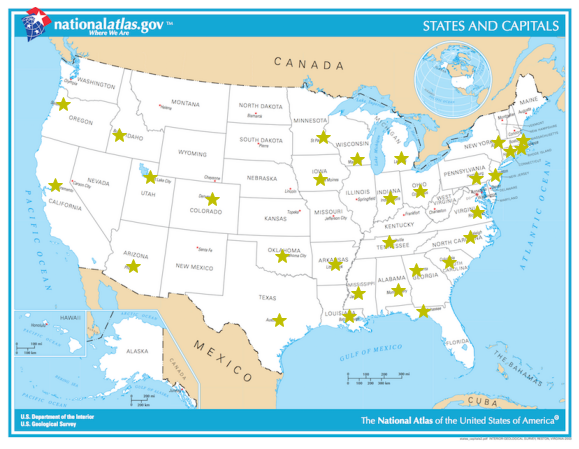

In [5]:
cities = { "Oklahoma City": (392.8, 356.4), "Montgomery": (559.6, 404.8), "Saint Paul": (451.6, 186.0), "Trenton": (698.8, 239.6), "Salt Lake City": (204.0, 243.2), "Columbus": (590.8, 263.2), "Austin": (389.2, 448.4), "Phoenix": (179.6, 371.2), "Hartford": (719.6, 205.2), "Baton Rouge": (489.6, 442.0), "Salem": (80.0, 139.2), "Little Rock": (469.2, 367.2), "Richmond": (673.2, 293.6), "Jackson": (501.6, 409.6), "Des Moines": (447.6, 246.0), "Lansing": (563.6, 216.4), "Denver": (293.6, 274.0), "Boise": (159.6, 182.8), "Raleigh": (662.0, 328.8), "Atlanta": (585.6, 376.8), "Madison": (500.8, 217.6), "Indianapolis": (548.0, 272.8), "Nashville": (546.4, 336.8), "Columbia": (632.4, 364.8), "Providence": (735.2, 201.2), "Boston": (738.4, 190.8), "Tallahassee": (594.8, 434.8), "Sacramento": (68.4, 254.0), "Albany": (702.0, 193.6), "Harrisburg": (670.8, 244.0) }
cities = list(sorted(cities.items()))

print(len(cities))

show_cities(cities)

7074

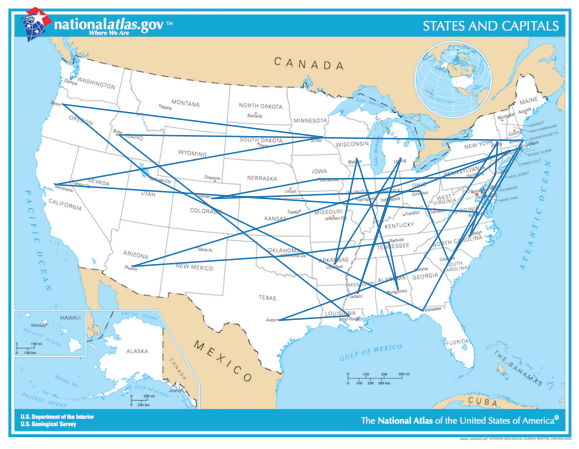

In [6]:
show_path(cities)

path_distance(cities)

**MEET THE ANT COLONY**

In [7]:
import time
from itertools import chain
from typing import Any, Callable, List, Tuple, Union

import numpy as np
import random



class AntColonySolver:
    def __init__(self,
                 cost_fn:                 Callable[[Any,Any], Union[float,int]],                         
                 
                 time=0,                  # run for a fixed amount of time
                 min_time=0,              # minimum runtime
                 timeout=0,               # maximum time in seconds to run for
                 stop_factor=2,           # how many times to redouble effort after new new best path
                 min_round_trips=10,      # minimum number of round trips before stopping
                 max_round_trips=0,       # maximum number of round trips before stopping                 
                 min_ants=0,              # Total number of ants to use
                 max_ants=0,              # Total number of ants to use
                 
                 ant_count=64,            # this is the bottom of the near-optimal range for numpy performance
                 ant_speed=1,             # how many steps do ants travel per epoch

                 distance_power=1,        # power to which distance affects pheromones                 
                 pheromone_power=1.25,    # power to which differences in pheromones are noticed
                 decay_power=0,           # how fast do pheromones decay
                 reward_power=0,          # relative pheromone reward based on best_path_length/path_length 
                 best_path_smell=2,       # queen multiplier for pheromones upon finding a new best path                  
                 start_smell=0,           # amount of starting pheromones [0 defaults to `10**self.distance_power`]

                 verbose=False,

    ):
        assert callable(cost_fn)        
        self.cost_fn         = cost_fn
        self.time            = int(time)
        self.min_time        = int(min_time)
        self.timeout         = int(timeout)
        self.stop_factor     = float(stop_factor)
        self.min_round_trips = int(min_round_trips)
        self.max_round_trips = int(max_round_trips)
        self.min_ants        = int(min_ants)
        self.max_ants        = int(max_ants)
    
        self.ant_count       = int(ant_count)
        self.ant_speed       = int(ant_speed)
        
        self.distance_power  = float(distance_power)     
        self.pheromone_power = float(pheromone_power)
        self.decay_power     = float(decay_power)
        self.reward_power    = float(reward_power)
        self.best_path_smell = float(best_path_smell)
        self.start_smell     = float(start_smell or 10**self.distance_power)
        
        self.verbose         = int(verbose)
        self._initalized     = False
        
        if self.min_round_trips and self.max_round_trips: self.min_round_trips = min(self.min_round_trips, self.max_round_trips)
        if self.min_ants and self.max_ants:               self.min_ants        = min(self.min_ants, self.max_ants)


    def solve_initialize(
            self,
            problem_path: List[Any],
    ) -> None:
        ### Cache of distances between nodes
        self.distances = {
            source: {
                dest: self.cost_fn(source, dest)
                for dest in problem_path
            }
            for source in problem_path
        }

        ### Cache of distance costs between nodes - division in a tight loop is expensive
        self.distance_cost = {
            source: {
                dest: 1 / (1 + self.distances[source][dest]) ** self.distance_power
                for dest in problem_path
            }
            for source in problem_path
        }

        ### This stores the pheromone trail that slowly builds up
        self.pheromones = {
            source: {
                # Encourage the ants to start exploring in all directions and furthest nodes
                dest: self.start_smell
                for dest in problem_path
            }
            for source in problem_path
        }
        
        ### Sanitise input parameters
        if self.ant_count <= 0:
            self.ant_count = len(problem_path)
        if self.ant_speed <= 0:
            self.ant_speed = np.median(list(chain(*[ d.values() for d in self.distances.values() ]))) // 5
        self.ant_speed = int(max(1,self.ant_speed))
        
        ### Heuristic Exports
        self.ants_used   = 0
        self.epochs_used = 0
        self.round_trips = 0
        self._initalized = True        


    def solve(self,
              problem_path: List[Any],
              restart=False,
    ) -> List[Tuple[int,int]]:
        if restart or not self._initalized:
            self.solve_initialize(problem_path)

        ### Here come the ants!
        ants = {
            "distance":    np.zeros((self.ant_count,)).astype('int32'),
            "path":        [ [ problem_path[0] ]   for n in range(self.ant_count) ],
            "remaining":   [ set(problem_path[1:]) for n in range(self.ant_count) ],
            "path_cost":   np.zeros((self.ant_count,)).astype('int32'),
            "round_trips": np.zeros((self.ant_count,)).astype('int32'),
        }

        best_path       = None
        best_path_cost  = np.inf
        best_epochs     = []
        epoch           = 0
        time_start      = time.perf_counter()
        while True:
            epoch += 1

            ### Vectorized walking of ants
            # Small optimization here, testing against `> self.ant_speed` rather than `> 0` 
            #       avoids computing ants_arriving in the main part of this tight loop
            ants_travelling = (ants['distance'] > self.ant_speed)
            ants['distance'][ ants_travelling ] -= self.ant_speed
            if all(ants_travelling):
                continue  # skip termination checks until the next ant arrives
            
            ### Vectorized checking of ants arriving
            ants_arriving       = np.invert(ants_travelling)
            ants_arriving_index = np.where(ants_arriving)[0]
            for i in ants_arriving_index:

                ### ant has arrived at next_node
                this_node = ants['path'][i][-1]
                next_node = self.next_node(ants, i)
                ants['distance'][i]  = self.distances[ this_node ][ next_node ]
                ants['remaining'][i] = ants['remaining'][i] - {this_node}
                ants['path_cost'][i] = ants['path_cost'][i] + ants['distance'][i]
                ants['path'][i].append( next_node )

                ### ant has returned home to the colony
                if not ants['remaining'][i] and ants['path'][i][0] == ants['path'][i][-1]:
                    self.ants_used  += 1
                    self.round_trips = max(self.round_trips, ants["round_trips"][i] + 1)

                    ### We have found a new best path - inform the Queen
                    was_best_path = False
                    if ants['path_cost'][i] < best_path_cost:
                        was_best_path  = True
                        best_path_cost = ants['path_cost'][i]
                        best_path      = ants['path'][i]
                        best_epochs   += [ epoch ]
                        if self.verbose:
                            print({
                                "path_cost":   int(ants['path_cost'][i]),
                                "ants_used":   self.ants_used,
                                "epoch":       epoch,
                                "round_trips": ants['round_trips'][i] + 1,
                                "clock":       int(time.perf_counter() - time_start),
                            })

                    ### leave pheromone trail
                    # doing this only after ants arrive home improves initial exploration
                    #  * self.round_trips has the effect of decaying old pheromone trails
                    # ** self.reward_power = -3 has the effect of encouraging ants to explore longer routes
                    #                           in combination with doubling pheromone for best_path
                    reward = 1
                    if self.reward_power: reward *= ((best_path_cost / ants['path_cost'][i]) ** self.reward_power)
                    if self.decay_power:  reward *= (self.round_trips ** self.decay_power)
                    for path_index in range( len(ants['path'][i]) - 1 ):
                        this_node = ants['path'][i][path_index]
                        next_node = ants['path'][i][path_index+1]
                        self.pheromones[this_node][next_node] += reward
                        self.pheromones[next_node][this_node] += reward
                        if was_best_path:
                            # Queen orders to double the number of ants following this new best path                            
                            self.pheromones[this_node][next_node] *= self.best_path_smell
                            self.pheromones[next_node][this_node] *= self.best_path_smell


                    ### reset ant
                    ants["distance"][i]     = 0
                    ants["path"][i]         = [ problem_path[0] ]
                    ants["remaining"][i]    = set(problem_path[1:])
                    ants["path_cost"][i]    = 0
                    ants["round_trips"][i] += 1


            ### Do we terminate?
            
            # Always wait for at least 1 solutions (note: 2+ solutions are not guaranteed)
            if not len(best_epochs): continue 
            
            # Timer takes priority over other constraints
            if self.time or self.min_time or self.timeout:
                clock = time.perf_counter() - time_start
                if self.time:
                    if clock > self.time: break
                    else:                 continue
                if self.min_time and clock < self.min_time: continue
                if self.timeout  and clock > self.timeout:  break
            
            # First epoch only has start smell - question: how many epochs are required for a reasonable result?
            if self.min_round_trips and self.round_trips <  self.min_round_trips: continue        
            if self.max_round_trips and self.round_trips >= self.max_round_trips: break

            # This factor is most closely tied to computational power                
            if self.min_ants and self.ants_used <  self.min_ants: continue        
            if self.max_ants and self.ants_used >= self.max_ants: break            
            
            # Lets keep redoubling our efforts until we can't find anything more
            if self.stop_factor and epoch > (best_epochs[-1] * self.stop_factor): break
                                
            # Nothing else is stopping us: Queen orders the ants to continue!      
            if True: continue
            
            
            
        ### We have (hopefully) found a near-optimal path, report back to the Queen
        self.epochs_used = epoch
        self.round_trips = np.max(ants["round_trips"])
        return best_path


    def next_node(self, ants, index):
        this_node   = ants['path'][index][-1]

        weights     = []
        weights_sum = 0
        if not ants['remaining'][index]: return ants['path'][index][0]  # return home
        for next_node in ants['remaining'][index]:
            if next_node == this_node: continue
            reward = (
                    self.pheromones[this_node][next_node] ** self.pheromone_power
                    * self.distance_cost[this_node][next_node]  # Prefer shorter paths
            )
            weights.append( (reward, next_node) )
            weights_sum   += reward

        # Pick a random path in proportion to the weight of the pheromone
        rand = random.random() * weights_sum
        for (weight, next_node) in weights:
            if rand > weight: rand -= weight
            else:             break
        return next_node
            
        
def AntColonyRunner(cities, verbose=False, plot=False, label={}, algorithm=AntColonySolver, **kwargs):
    solver     = algorithm(cost_fn=distance, verbose=verbose, **kwargs)
    start_time = time.perf_counter()
    result     = solver.solve(cities)
    stop_time  = time.perf_counter()
    if label: kwargs = { **label, **kwargs }
        
    for key in ['verbose', 'plot', 'animate', 'label', 'min_time', 'max_time']:
        if key in kwargs: del kwargs[key]
    print("N={:<3d} | {:5.0f} -> {:4.0f} | {:4.0f}s | ants: {:5d} | trips: {:4d} | "
          .format(len(cities), path_distance(cities), path_distance(result), (stop_time - start_time), solver.ants_used, solver.round_trips)
          + " ".join([ f"{k}={v}" for k,v in kwargs.items() ])
    )
    if plot:
        show_path(result)
    return result

**SOLVING THE TRAVELING SALESMAN PROBLEM**

{'path_cost': 4411, 'ants_used': 1, 'epoch': 3913, 'round_trips': 1, 'clock': 0}
{'path_cost': 3805, 'ants_used': 65, 'epoch': 7466, 'round_trips': 2, 'clock': 0}
{'path_cost': 3458, 'ants_used': 92, 'epoch': 9858, 'round_trips': 2, 'clock': 0}
{'path_cost': 3260, 'ants_used': 127, 'epoch': 11500, 'round_trips': 3, 'clock': 0}
{'path_cost': 3252, 'ants_used': 142, 'epoch': 12907, 'round_trips': 3, 'clock': 0}
{'path_cost': 3179, 'ants_used': 144, 'epoch': 13003, 'round_trips': 3, 'clock': 0}
{'path_cost': 3130, 'ants_used': 168, 'epoch': 14046, 'round_trips': 4, 'clock': 0}
{'path_cost': 2791, 'ants_used': 200, 'epoch': 15837, 'round_trips': 4, 'clock': 0}
{'path_cost': 2463, 'ants_used': 213, 'epoch': 16309, 'round_trips': 5, 'clock': 0}
N=30  |  7074 -> 2476 |    1s | ants:   581 | trips:   10 | distance_power=1


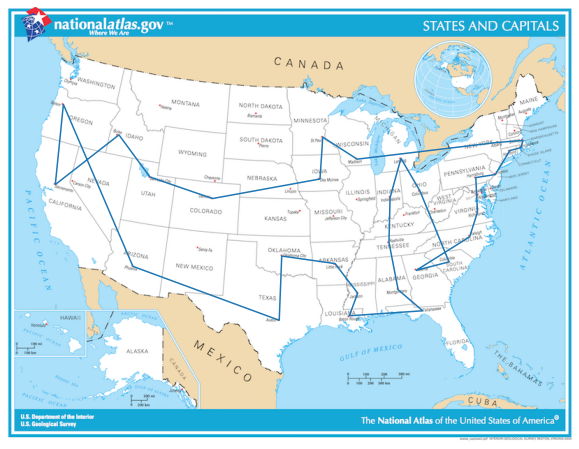

In [8]:
results = AntColonyRunner(cities, distance_power=1, verbose=True, plot=True)

**SOLVING WITH WILD ANTS**

{'path_cost': 6772, 'ants_used': 1, 'epoch': 6138, 'round_trips': 1, 'clock': 0}
{'path_cost': 6759, 'ants_used': 2, 'epoch': 6261, 'round_trips': 1, 'clock': 0}
{'path_cost': 6557, 'ants_used': 3, 'epoch': 6386, 'round_trips': 1, 'clock': 0}
{'path_cost': 6478, 'ants_used': 5, 'epoch': 6421, 'round_trips': 1, 'clock': 0}
{'path_cost': 5949, 'ants_used': 65, 'epoch': 11949, 'round_trips': 2, 'clock': 0}
{'path_cost': 5582, 'ants_used': 66, 'epoch': 12555, 'round_trips': 2, 'clock': 0}
{'path_cost': 5383, 'ants_used': 130, 'epoch': 19392, 'round_trips': 3, 'clock': 0}
{'path_cost': 5021, 'ants_used': 194, 'epoch': 25038, 'round_trips': 4, 'clock': 0}
{'path_cost': 4789, 'ants_used': 259, 'epoch': 31143, 'round_trips': 5, 'clock': 0}
{'path_cost': 4473, 'ants_used': 333, 'epoch': 38650, 'round_trips': 6, 'clock': 0}
{'path_cost': 4450, 'ants_used': 395, 'epoch': 43986, 'round_trips': 7, 'clock': 0}
{'path_cost': 4417, 'ants_used': 472, 'epoch': 50021, 'round_trips': 8, 'clock': 0}
{'path

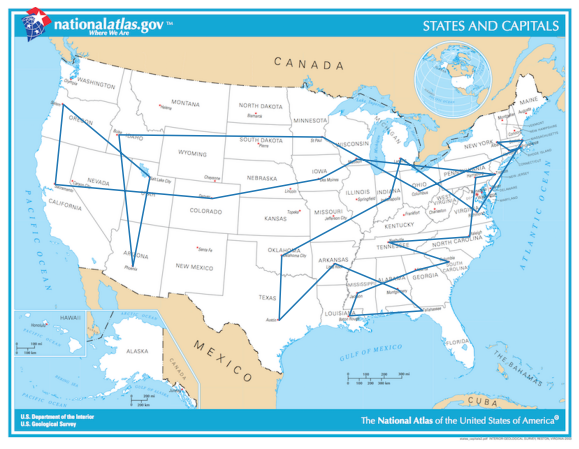

In [9]:
results = AntColonyRunner(cities, distance_power=0, stop_factor=1.25, verbose=True, plot=True)

{'path_cost': 6302, 'ants_used': 1, 'epoch': 6041, 'round_trips': 1, 'clock': 0}
{'path_cost': 5988, 'ants_used': 65, 'epoch': 12349, 'round_trips': 2, 'clock': 0}
{'path_cost': 5733, 'ants_used': 68, 'epoch': 13386, 'round_trips': 2, 'clock': 0}
{'path_cost': 5592, 'ants_used': 210, 'epoch': 27625, 'round_trips': 4, 'clock': 0}
{'path_cost': 5552, 'ants_used': 259, 'epoch': 32550, 'round_trips': 5, 'clock': 0}
{'path_cost': 5241, 'ants_used': 261, 'epoch': 32693, 'round_trips': 5, 'clock': 0}
{'path_cost': 5209, 'ants_used': 300, 'epoch': 36094, 'round_trips': 5, 'clock': 0}
{'path_cost': 4685, 'ants_used': 361, 'epoch': 41788, 'round_trips': 6, 'clock': 0}
{'path_cost': 4618, 'ants_used': 387, 'epoch': 44330, 'round_trips': 7, 'clock': 0}
{'path_cost': 4172, 'ants_used': 542, 'epoch': 57660, 'round_trips': 9, 'clock': 0}
{'path_cost': 4019, 'ants_used': 1559, 'epoch': 140727, 'round_trips': 25, 'clock': 2}
{'path_cost': 4011, 'ants_used': 2620, 'epoch': 224538, 'round_trips': 42, 'cl

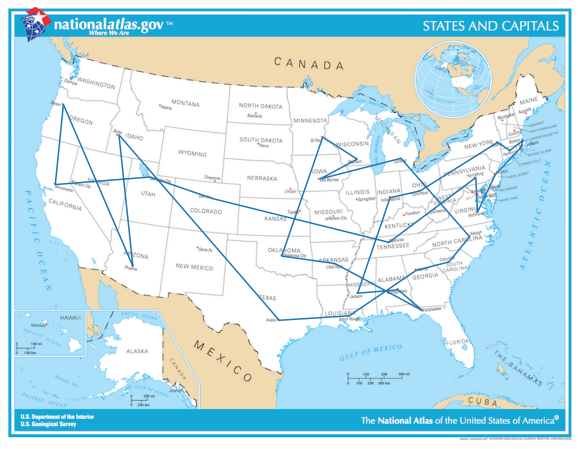

In [10]:
results = AntColonyRunner(cities, distance_power=0, min_time=30, verbose=True, plot=True)

**STATISTICAL RANDOM VARIABLE**

In [11]:
results_converged = [ AntColonyRunner(cities) for i in range(10) ]

N=30  |  7074 -> 2281 |    1s | ants:   942 | trips:   15 | 
N=30  |  7074 -> 2372 |    2s | ants:  1473 | trips:   24 | 
N=30  |  7074 -> 2250 |    1s | ants:  1293 | trips:   21 | 
N=30  |  7074 -> 2261 |    2s | ants:  1767 | trips:   29 | 
N=30  |  7074 -> 2264 |    1s | ants:  1437 | trips:   23 | 
N=30  |  7074 -> 2334 |    2s | ants:  1461 | trips:   24 | 
N=30  |  7074 -> 2218 |    1s | ants:  1474 | trips:   24 | 
N=30  |  7074 -> 2198 |    2s | ants:  1651 | trips:   27 | 
N=30  |  7074 -> 2518 |    3s | ants:  2769 | trips:   44 | 
N=30  |  7074 -> 2276 |    2s | ants:  1633 | trips:   27 | 


In [12]:
results_timed = [ AntColonyRunner(cities, time=10) for i in range(10) ]

N=30  |  7074 -> 2243 |   10s | ants: 10788 | trips:  170 | time=10
N=30  |  7074 -> 2422 |   10s | ants: 10292 | trips:  162 | time=10
N=30  |  7074 -> 2233 |   10s | ants: 10754 | trips:  169 | time=10
N=30  |  7074 -> 2295 |   10s | ants: 10696 | trips:  168 | time=10
N=30  |  7074 -> 2342 |   10s | ants: 10680 | trips:  168 | time=10
N=30  |  7074 -> 2236 |   10s | ants: 10474 | trips:  165 | time=10
N=30  |  7074 -> 2215 |   10s | ants: 10682 | trips:  169 | time=10
N=30  |  7074 -> 2268 |   10s | ants: 10368 | trips:  164 | time=10
N=30  |  7074 -> 2350 |   10s | ants: 10503 | trips:  166 | time=10
N=30  |  7074 -> 2299 |   10s | ants: 10483 | trips:  165 | time=10


In [13]:
import pandas as pd
results_converged_stats = pd.Series([ path_distance(path) for path in results_converged ]).describe()
results_timed_stats     = pd.Series([ path_distance(path) for path in results_timed     ]).describe()
pd.DataFrame({
    "results_converged": results_converged_stats,
    "results_timed":     results_timed_stats,
    "difference":        results_converged_stats - results_timed_stats,
}).T.round(1)

,count,mean,std,min,25%,50%,75%,max
results_converged,10.0,2297.2,92.6,2198.0,2252.8,2270.0,2320.8,2518.0
results_timed,10.0,2290.3,65.2,2215.0,2237.8,2281.5,2331.2,2422.0
difference,0.0,6.9,27.3,-17.0,15.0,-11.5,-10.5,96.0


**HYPERPARAMETER OPTIMIZATION**

In [ ]:
#ant_count

for ant_count in range(0,16+1):
    AntColonyRunner(cities, ant_count=2**ant_count, time=60)

N=30  |  7074 -> 2532 |   60s | ants:  3654 | trips: 3654 | ant_count=1 time=60
N=30  |  7074 -> 2493 |   60s | ants:  7999 | trips: 4000 | ant_count=2 time=60
N=30  |  7074 -> 2326 |   60s | ants: 15487 | trips: 3873 | ant_count=4 time=60
N=30  |  7074 -> 2441 |   60s | ants: 23681 | trips: 2963 | ant_count=8 time=60
N=30  |  7074 -> 2357 |   60s | ants: 36169 | trips: 2263 | ant_count=16 time=60
N=30  |  7074 -> 2440 |   60s | ants: 50449 | trips: 1579 | ant_count=32 time=60
N=30  |  7074 -> 2307 |   60s | ants: 63867 | trips: 1000 | ant_count=64 time=60
N=30  |  7074 -> 2272 |   60s | ants: 75329 | trips:  591 | ant_count=128 time=60
N=30  |  7074 -> 2217 |   60s | ants: 86846 | trips:  341 | ant_count=256 time=60
N=30  |  7074 -> 2230 |   60s | ants: 91793 | trips:  180 | ant_count=512 time=60
N=30  |  7074 -> 2196 |   60s | ants: 93232 | trips:   93 | ant_count=1024 time=60
N=30  |  7074 -> 2186 |   60s | ants: 95469 | trips:   48 | ant_count=2048 time=60
N=30  |  7074 -> 2178 |  

In [ ]:
#min_ants

for N in range(8,30+1):
    best = { "ant_count": 0, "min_ants": 0, "path": None, "count": 0 }
    for ant_count in [8,16,32,64,128,256,512,1024,2048]:
        for min_ants in [64,128,256,512,1024,2048,4096,8192]:
            result = AntColonySolver(ant_count=ant_count, min_ants=min_ants, cost_fn=distance).solve(cities[:N])
            if not best['path'] or best['path'] > path_distance(result):
                best = { "ant_count": ant_count, "min_ants": min_ants, "path": path_distance(result), "count": best['count']+1 }
                continue
            if best['count'] >= 3: 
                best['count'] = 0
                break
    AntColonyRunner(cities[:N], ant_count=best['ant_count'], min_ants=best['min_ants'])

In [ ]:
#ant_speed

for ant_speed in list(range(0,10+1)):
    result = AntColonyRunner(cities, ant_speed=2**ant_speed, time=10)
result = AntColonyRunner(cities, ant_speed=0, time=10)

In [ ]:
#distance_power

for distance_power in [-2.0, -1.0, 0.0, 0.5, 1.0, 1.25, 1.5, 1.75, 2.0, 3.0, 5.0, 10.0]:
    result = AntColonyRunner(cities, distance_power=distance_power, timeout=60)

In [ ]:
#pheromone_power

for distance_power in [0,1,2]:
    for pheromone_power in [-2.0, -1.0, 0.0, 0.5, 1.0, 1.25, 1.5, 1.75, 2.0, 3.0, 5.0, 10.0]:
        result = AntColonyRunner(cities, distance_power=distance_power, pheromone_power=pheromone_power, time=0)
    print()

In [ ]:
for distance_power in [0,1,2]:
    for pheromone_power in [1.0, 1.1, 1.2, 1.3, 1.4]:
        result = AntColonyRunner(cities, distance_power=distance_power, pheromone_power=pheromone_power, time=0)
    print()

In [ ]:
#decay_power

for pheromone_power in [1.0, 1.25]:
    for distance_power in [0,1,2]:
        for decay_power in [-1.0, 0.0, 1.0, 1.25, 1.5, 2.0, 3.0]:
            result = AntColonyRunner(cities, pheromone_power=pheromone_power, distance_power=distance_power, decay_power=decay_power, time=15)
        print()
    print()

In [ ]:
for distance_power in [0,1,2]:
    for decay_power in [-2.0, -1.0, 0.0, 0.5, 1.0, 1.25, 1.5, 2.0, 3.0, 5.0, 10.0]:
        result = AntColonyRunner(cities, distance_power=distance_power, decay_power=decay_power, time=0)
    print()

In [ ]:
#reward_power

for decay_power in [-2.0, -1.0, 0.0, 0.5, 1.0, 1.25, 1.5, 2.0, 3.0, 5.0, 10.0]:
    result = AntColonyRunner(cities, decay_power=decay_power, timeout=60)
    print()

In [ ]:
for decay_power in [-2.0, -1.0, 0.0, 0.5, 1.0, 1.25, 1.5, 2.0, 3.0, 5.0, 10.0]:
    for reward_power in range(-5,5+1):
        result = AntColonyRunner(cities, decay_power=decay_power, reward_power=reward_power, time=15)
    print()

In [ ]:
#best_path_smell

for distance_power in [0,1,2]:
    for best_path_smell in [0.0, 0.5, 1.0, 1.25, 1.5, 2.0, 3.0, 5.0, 10.0]:
        result = AntColonyRunner(cities, distance_power=distance_power, best_path_smell=best_path_smell, time=15)
    print()

In [ ]:
for distance_power in [0,1,2]:
    for best_path_smell in [0.0, 0.5, 1.0, 1.25, 1.5, 2.0, 3.0, 5.0, 10.0]:
        result = AntColonyRunner(cities, distance_power=distance_power, best_path_smell=best_path_smell, min_round_trips=20, time=0)
    print()

In [ ]:
#start_smell

for distance_power in [0, 1, 2]:
    for start_smell in list(range(0,8)):
        result = AntColonyRunner(cities, distance_power=distance_power, start_smell=10**start_smell, time=15)
    result = AntColonyRunner(cities, distance_power=distance_power, start_smell=0, time=15)
    print()

In [ ]:
#stop_factor

for distance_power in [0, 1, 2]:
    for stop_factor in [1.25, 1.5, 1.75, 2, 5]:
        result = AntColonyRunner(cities, distance_power=distance_power, stop_factor=stop_factor)
    print()

**NP HARD SCALABILITY**

In [ ]:
import string
def create_cities(size, max_x=1000, max_y=1000, image=None, color=1, border=30):
    if (image is not None):
        max_x = image.shape[0] - 1 - border*2
        max_y = image.shape[1] - 1 - border*2
    cities = {}
    while len(cities) <= size:
        name = ''.join(random.choices(string.ascii_lowercase, k=10))
        x = round( border + random.random() * max_x,  1)
        y = round( border + random.random() * max_y,  1)
        if (image is not None) and not all( image[int(x)][int(y)] == color ): continue
        cities[(int(x),int(y))] = ( name, (y,x) )               
    return list(cities.values())

np_hard = create_cities(256, image=united_states_map)
print(np_hard[:5])
show_cities(np_hard)

In [ ]:
#First let look at some of the smaller problems
#For the smallest problems N<8 most of the time is spent just marching 1024 ants for a minimum of 4 round trips
#Running to convergance takes exponentally longer for each doubling of the problem size
#The ants can still find a reasonable path for N=64

for N in [8,16,32,64,128,256]:
    result = AntColonyRunner(np_hard[:N], label={ "N": N }, timeout=60*60)
    plt.figure()
    plt.title(f'N={N}')        
    show_path(result)    
print()

In [ ]:
#Lets limit time complexity to N^2

for N in [8,16,32,64,128,256]:
    result = AntColonyRunner(np_hard[:N], label={ "N": N }, max_ants=N**2, timeout=60*60)
    plt.figure()
    plt.title(f'N={N}')    
    show_path(result)        
print()

In [ ]:
#What if we enable cheat mode with distance_power=10
#Thus works quicker and faster than relying on the pheromone trail
#Even with an N^2 limitation on the ants, there is still an 14 minute runtime on N=256

for N in [8,16,32,64,128,256]:
    result = AntColonyRunner(np_hard[:N], label={ "N": N }, distance_power=10, max_ants=N**2, timeout=60*60)
    plt.figure()
    plt.title(f'N={N}')
    show_path(result)            
print()